# DeepInsight

This repository contains the original MatLab code for DeepInsight as described in 
the paper [DeepInsight: A methodology to transform a non-image data to an image 
for convolution neural network architecture][1].

# pyDeepInsight

This package provides a python version of the image transformation procedure of 
DeepInsight. This is not guaranteed to give the same results as the published
MatLab code and should be considered experimental.

## Installation
    python -m pip -q install git+git://github.com/alok-ai-lab/DeepInsight.git#egg=DeepInsight
    
[1]: https://doi.org/10.1038/s41598-019-47765-6

## Usage

The following is a walkthrough of standard usage of the ImageTransformer class

In [1]:
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

Load example TCGA data

In [2]:
expr_file = r"./examples/data/tcga.rnaseq_fpkm_uq.example.txt.gz"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['project'].values
X = expr.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)
X_train.shape

(480, 5000)

Normalize data to values between 0 and 1. The following normalization 
procedure is described in the 
[DeepInsight paper supplementary information](
https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-019-47765-6/MediaObjects/41598_2019_47765_MOESM1_ESM.pdf)
as norm-2.

In [3]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

Initialize image transformer.

In [4]:
it = ImageTransformer(feature_extractor='tsne', 
                      pixels=50, random_state=1701, 
                      n_jobs=-1)

Train image transformer on training data. Setting plot=True results in at 
a plot showing the reduced features (blue points), convex full (red), and 
minimum bounding rectagle (green) prior to rotation.

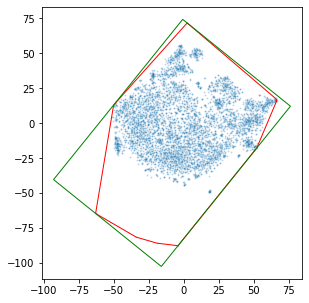

In [5]:
plt.figure(figsize=(5, 5))
it.fit(X_train_norm, plot=True)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

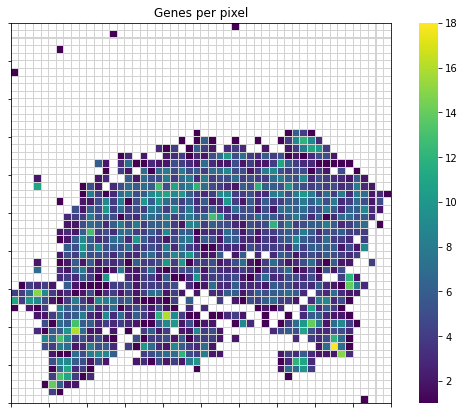

In [6]:
fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

It is possible to update the pixel size without retraining.

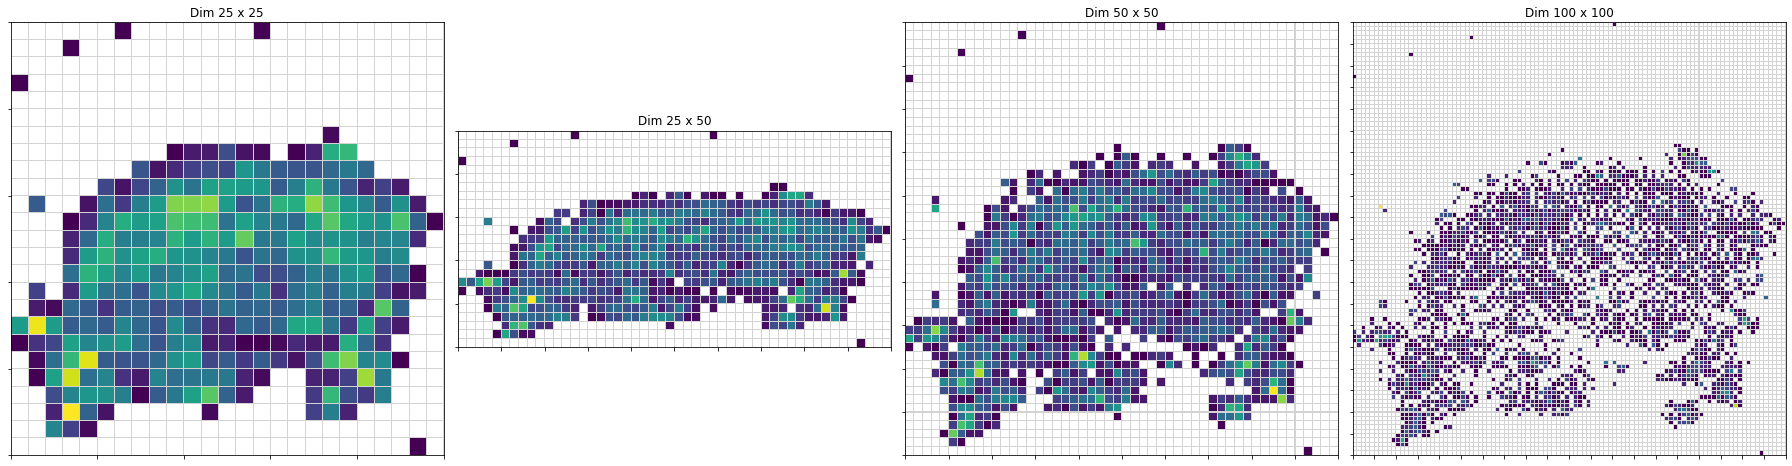

In [7]:
px_sizes = [25, (25, 50), 50, 100]

fig, ax = plt.subplots(1, len(px_sizes), figsize=(25, 7))
for ix, px in enumerate(px_sizes):
    it.pixels = px
    fdm = it.feature_density_matrix()
    fdm[fdm == 0] = np.nan
    cax = sns.heatmap(fdm, cmap="viridis", linewidth=0.01, 
                      linecolor="lightgrey", square=True, 
                      ax=ax[ix], cbar=False)
    cax.set_title('Dim {} x {}'.format(*it.pixels))
    for _, spine in cax.spines.items():
        spine.set_visible(True)
    cax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    cax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.tight_layout()    
    
it.pixels = 50

The trained transformer can then be used to transform sample data to image 
matricies.

In [8]:
X_train_img = it.transform(X_train_norm)

Fit and transform can be done in a single step.

In [9]:
X_train_img = it.fit_transform(X_train_norm)

The following are showing plots for the image matrices first four samples 
of the training set. 

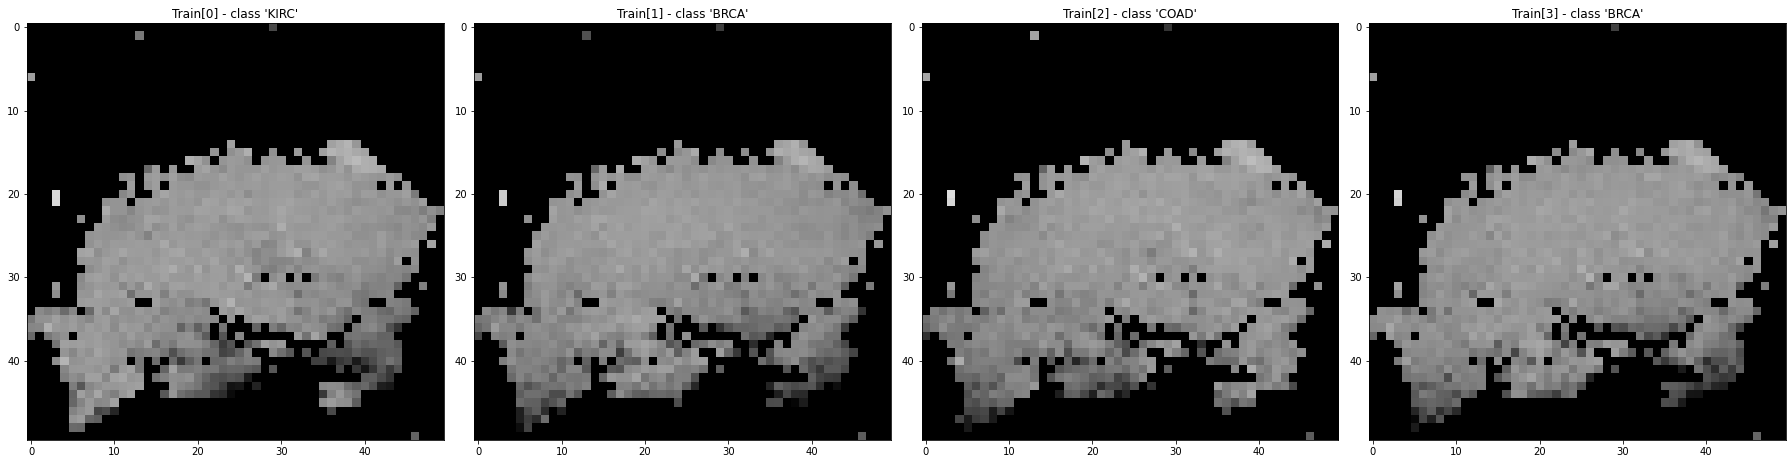

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text("Train[{}] - class '{}'".format(i, y_train[i]))
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

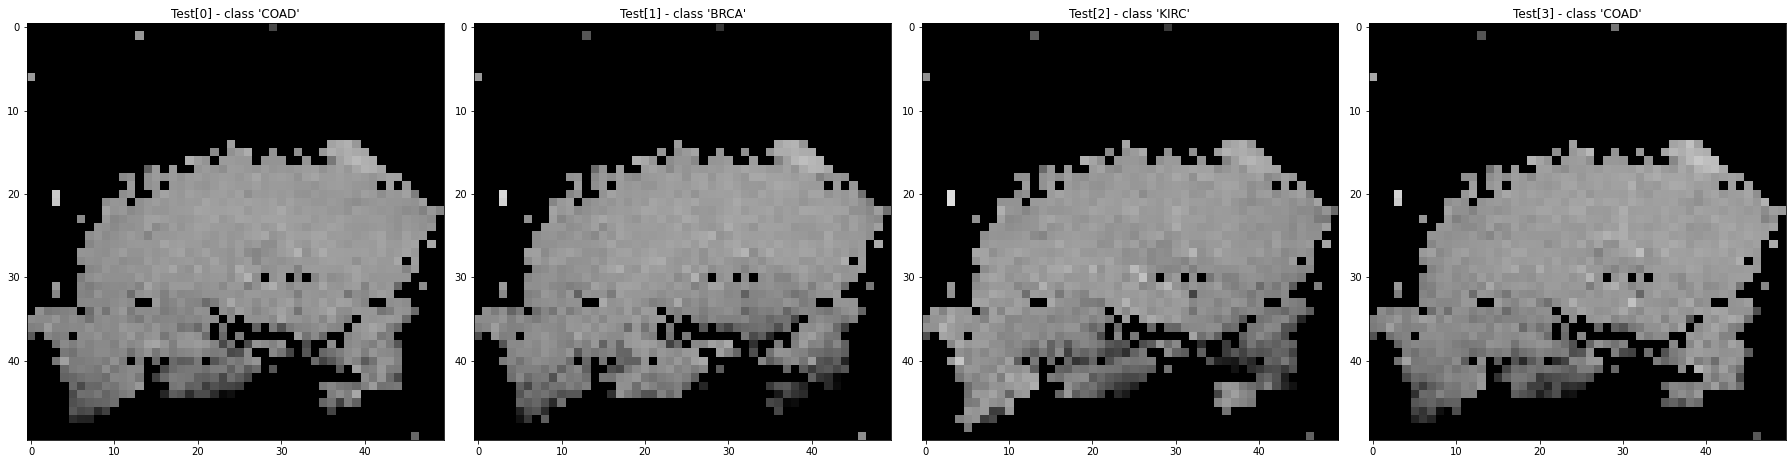

In [11]:
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text("Test[{}] - class '{}'".format(i, y_test[i]))
plt.tight_layout()

The images matrices can then be used as impute for the CNN model.